In [21]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

### Read in

In [3]:
path = '/nas/cee-water/cjgleason/ellie/SWOT/orbitMS/data/scaling/all_q_swot_sword_scaling2000_FS_SO.csv'

In [4]:
df = pd.read_csv(path)

In [37]:
df.xtrk_dist

0        39552.07812
1       -16272.20557
2        32685.72266
3                NaN
4                NaN
            ...     
87907            NaN
87908            NaN
87909    17907.82422
87910    17907.82422
87911    46065.58203
Name: xtrk_dist, Length: 87912, dtype: float64

In [32]:
df.columns

Index(['algo', 'reach_id', 'time', 'Q', 'd_x_area', 'd_x_area_u', 'slope',
       'slope_u', 'slope_r_u', 'slope2', 'slope2_u', 'slope2_r_u', 'width',
       'p_width', 'width_u', 'wse', 'wse_u', 'wse_r_u', 'p_length', 'reach_q',
       'reach_q_b', 'dark_frac', 'ice_clim_f', 'ice_dyn_f', 'partial_f',
       'n_good_nod', 'obs_frac_n', 'xovr_cal_q', 'xtrk_dist', 'x', 'y',
       'reach_len', 'n_nodes', 'wse_sword', 'wse_var_sword', 'width_sword',
       'width_var_sword', 'facc', 'n_chan_max', 'n_chan_mod', 'obstr_type',
       'grod_id', 'hfalls_id', 'slope_sword', 'dist_out', 'lakeflag',
       'max_width', 'n_rch_up', 'n_rch_dn', 'rch_id_up', 'rch_id_dn',
       'swot_orbit', 'swot_obs', 'type', 'river_name', 'edit_flag',
       'trib_flag', 'layer', 'path', 'Random', 'geometry', 'count',
       'count_algo', 'fraction_before', 'unique_algos_count', 'color'],
      dtype='object')

In [15]:
df_fs = df[df['time'] < '2023-07-11']

In [17]:
df_so = df[df['time'] >= '2023-07-11']

In [25]:
fsReachList = list(df.reach_id.unique())

In [18]:
subset = df.iloc[0:10].reach_id

### Histograms

In [10]:
# Function to plot histograms for all columns in a grid layout
def plot_histograms(df, n_cols=3):
    # Replace fill value -999999999999.0 with NaN
    df = df.replace(-999999999999.0, pd.NA)

    # Calculate the number of rows and columns needed
    n_rows = math.ceil(len(df.columns) / n_cols)

    # Create a grid of subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
    axes = axes.flatten()  # Flatten in case of excess subplots

    # Plot each column in its own subplot
    for i, column in enumerate(df.columns):
        df[column].dropna().hist(bins=50, ax=axes[i])
        axes[i].set_title(column, fontsize=25)

        # Set font size for x and y ticks
        axes[i].tick_params(axis='x', labelsize=20, rotation=45)
        axes[i].tick_params(axis='y', labelsize=20)

    # Hide any unused axes if there are extra subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

In [14]:
plot_histograms(df)

In [67]:
#Width-Height relationships
def plot_individual_timeseries_for_reach_ids(dfs, reach_ids):
    """
    Plot individual time series for the given reach_ids in the DataFrames.

    Parameters:
    dfs (list): List of DataFrames, each with columns 'time_str', 'wse', 'width', and 'reach_id'.
    reach_ids (list): List of reach_id values to plot.

    Returns:
    DataFrame: DataFrame with regression parameters for each reach_id.
    """
    marker_styles = ['X','<','s', 'D', 'o', 'P', '^', 'v',  '>', '*', 'h', '+']
    colors = ['black', 'blue', 'red']  # Define colors for each DataFrame
    cmaps = ['Grays', 'winter', 'winter']
    orbits = ['all', 'FS', 'SO']

    # Initialize dictionary to store regression parameters with NaN
    regression_params = {
        'reach_id': reach_ids,
        'samples_all': [np.nan] * len(reach_ids), 'slope_all': [np.nan] * len(reach_ids),
        'intercept_all': [np.nan] * len(reach_ids), 'r2_all': [np.nan] * len(reach_ids),
        'standard_error_all': [np.nan] * len(reach_ids),
        'standard_dev_all': [np.nan] * len(reach_ids),
        'samples_FS': [np.nan] * len(reach_ids), 'slope_FS': [np.nan] * len(reach_ids),
        'intercept_FS': [np.nan] * len(reach_ids), 'r2_FS': [np.nan] * len(reach_ids),
        'standard_error_FS': [np.nan] * len(reach_ids),
        'standard_dev_FS': [np.nan] * len(reach_ids),
        'samples_SO': [np.nan] * len(reach_ids), 'slope_SO': [np.nan] * len(reach_ids),
        'intercept_SO': [np.nan] * len(reach_ids), 'r2_SO': [np.nan] * len(reach_ids),
        'standard_error_SO': [np.nan] * len(reach_ids),
        'standard_dev_SO': [np.nan] * len(reach_ids)

    }

    # Loop through each reach_id and create an individual plot
    for reach_id in reach_ids:
        #print(reach_id)
        fig, ax1 = plt.subplots(figsize=(14, 9))
        data_exists = False

        for i, df in enumerate(dfs):
            # Ensure 'time_str' column is in datetime format
            df.loc[:, 'time'] = pd.to_datetime(df['time'])

            # Filter the DataFrame for the current reach_id
            sub_df = df[df['reach_id'] == reach_id]
            # Filter out rows with invalid error values (-999999999999.0) in any of the error columns
            sub_df = sub_df[(sub_df['wse_u'] != -999999999999.0) & (sub_df['width_u'] != -999999999999.0)]

            # Drop rows with NaN values in 'width' or 'wse' or any other necessary column
            sub_df = sub_df.dropna(subset=['width', 'wse', 'width_u', 'wse_u'])
            # Check if the sub_df has any data
            if not sub_df.empty:
                data_exists = True
                river_name = sub_df['river_name'].unique()


                # Plot time series for the current reach_id from the current DataFrame
                alpha_value = 0 if i == 0 else 1  # Make first DataFrame points semi-transparent

                # Get uncertainties if available
                x_err = sub_df['width_u'] if 'width_u' in sub_df.columns else None
                y_err = sub_df['wse_u'] if 'wse_u' in sub_df.columns else None
                
                if i != 0:
                    sub_df['xtrk_dist'] = np.abs(sub_df['xtrk_dist'])
                    xtrk_norm = (sub_df['xtrk_dist'] - sub_df['xtrk_dist'].min()) / (sub_df['xtrk_dist'].max() - sub_df['xtrk_dist'].min())
                    # # Plot the data with error bars
                    # scatter = ax1.errorbar(sub_df['width'], sub_df['wse'],
                    #                        xerr=x_err, yerr=y_err,
                    #                        label=f'Orbit: {orbits[i]}',
                    #                        fmt=marker_styles[i % len(marker_styles)],
                    #                        c=np.abs(xtrk_norm),
                    #                        cmap=colors[i], alpha=alpha_value,
                    #                        linestyle='None')

                    # Create scatter plot with colors mapped from xtrk_norm
                    scatter = ax1.scatter(sub_df['width'], sub_df['wse'],
                                          c=xtrk_norm, cmap=cmaps[i],  # Colormap can be chosen here
                                          label=f'Orbit: {orbits[i]}',
                                          marker=marker_styles[i % len(marker_styles)],
                                          s=100, edgecolors='black', alpha=alpha_value)

                    # Add color bar to indicate the scale of xtrk_norm
                    cbar = plt.colorbar(scatter, ax=ax1)
                    cbar.set_label('Normalized Track Distance', fontsize=12)

                # Calculate and plot the line of best fit
                X = sub_df[['width']].values.reshape(-1, 1)  # Predictor
                y = sub_df['wse'].values  # Response

                if len(X) >= 10:  # Ensure there's more than one point
                    # Fit linear regression model
                    model = LinearRegression()
                    model.fit(X, y)
                    y_pred = model.predict(X)

                    # Calculate R^2 value
                    r2 = model.score(X, y)
                    # Get the slope and intercept
                    slope = model.coef_[0]
                    intercept = model.intercept_

                    # Calculate residual sum of squares and standard error
                    residual_sum_of_squares = np.sum((y - y_pred) ** 2)
                    standard_error = np.sqrt(residual_sum_of_squares / (len(X) - 2))
                    standard_dev = standard_error * np.sqrt(len(X))
                    # Update regression parameters
                    reach_index = reach_ids.index(reach_id)
                    regression_params[f'samples_{orbits[i]}'][reach_index] = len(X)
                    regression_params[f'slope_{orbits[i]}'][reach_index] = slope
                    regression_params[f'intercept_{orbits[i]}'][reach_index] = intercept
                    regression_params[f'r2_{orbits[i]}'][reach_index] = r2
                    regression_params[f'standard_error_{orbits[i]}'][reach_index] = standard_error
                    regression_params[f'standard_dev_{orbits[i]}'][reach_index] = standard_dev

                    # Plot the line of best fit with the same color
                    ax1.plot(sub_df['width'], y_pred, color=colors[i], linestyle='--',
                             label=f'Best Fit Line (R^2 = {r2:.2f}), Slope = {slope:.4f})')

#                     # Calculate confidence intervals
#                     n = len(X)
#                     mean_x = np.mean(X)
#                     t_value = t.ppf(1 - 0.05 / 2, df=n-2)  # 95% confidence interval

#                     x_var = np.sum((X.flatten() - mean_x)**2)
#                     # Create sorted x-values for CI
#                     X_sorted = np.sort(X.flatten())
#                     y_pred_sorted = model.predict(X_sorted.reshape(-1, 1))
#                     ci = t_value * standard_error * np.sqrt(1/n + (X_sorted - mean_x)**2 / x_var)

#                     # Plot confidence intervals
#                     ax1.fill_between(X_sorted,
#                                      y_pred_sorted - ci,
#                                      y_pred_sorted + ci,
#                                      color=colors[i], alpha=0.2)

        # Only display the plot if there is data
        if not sub_df.empty:
            # Add labels, title, and legend
            ax1.set_xlabel('Width (m)', fontsize=16)
            ax1.set_ylabel('WSE (m)', fontsize=16)
            ax1.set_title(f'Time Series of WSE for Reach ID: {reach_id}, {river_name[0]}', fontsize=18)

            # Add legends
            lines1, labels1 = ax1.get_legend_handles_labels()
            ax1.legend(lines1, labels1, title=f'Reach ID: {reach_id}', title_fontsize='13', fontsize='12')

            # Display the plot
            plt.tight_layout()
            plt.show()
        else:
            plt.close(fig)

    # Create DataFrame from regression parameters dictionary
    regression_df = pd.DataFrame(regression_params)
    return regression_df

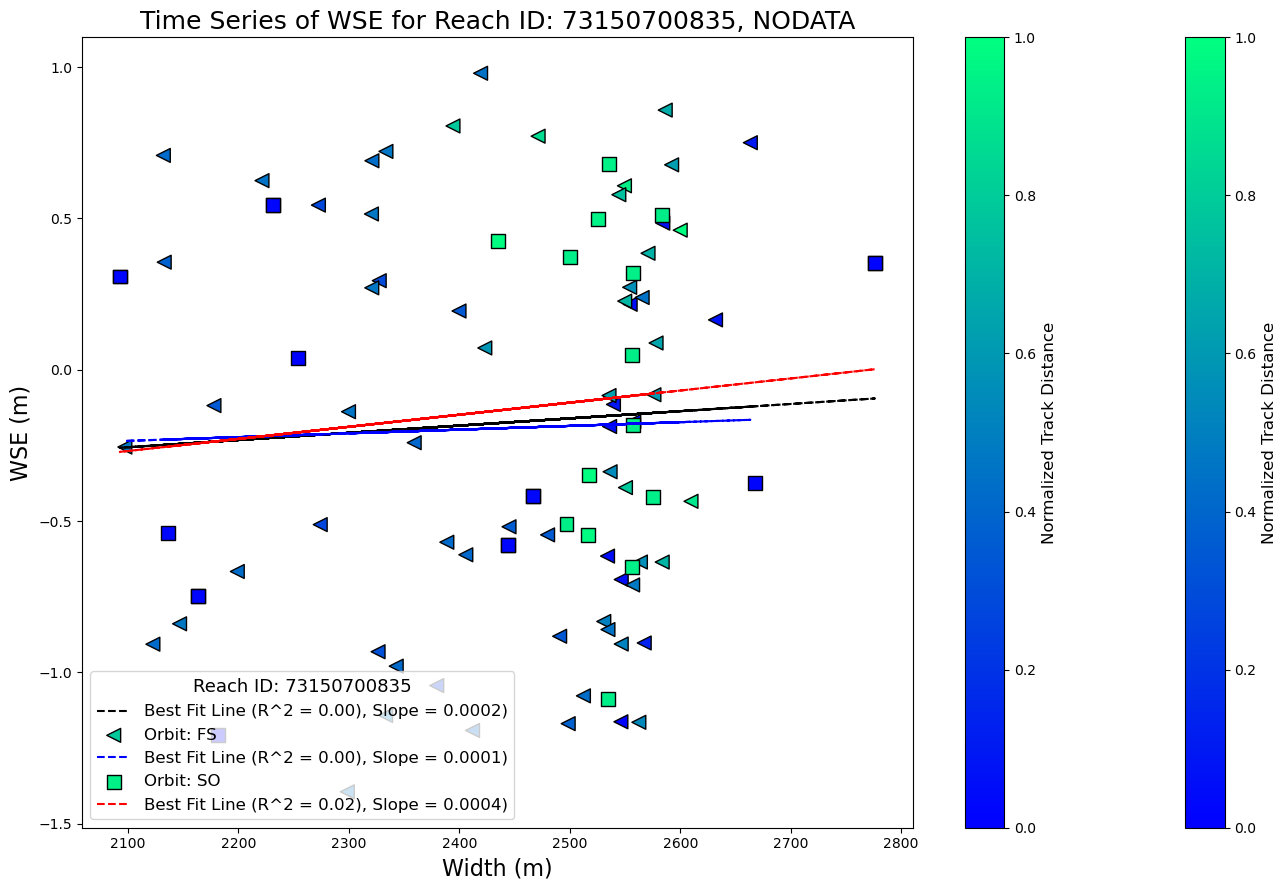

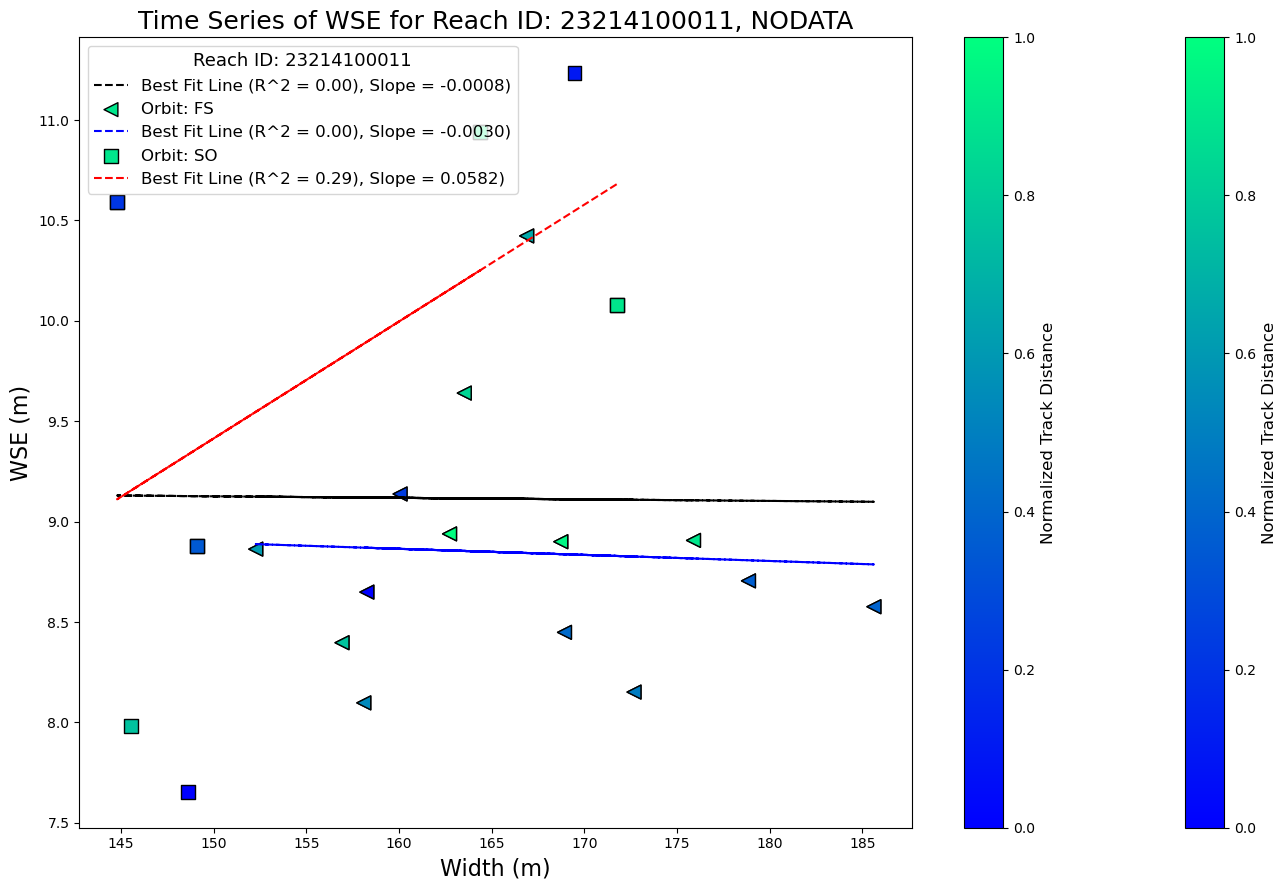

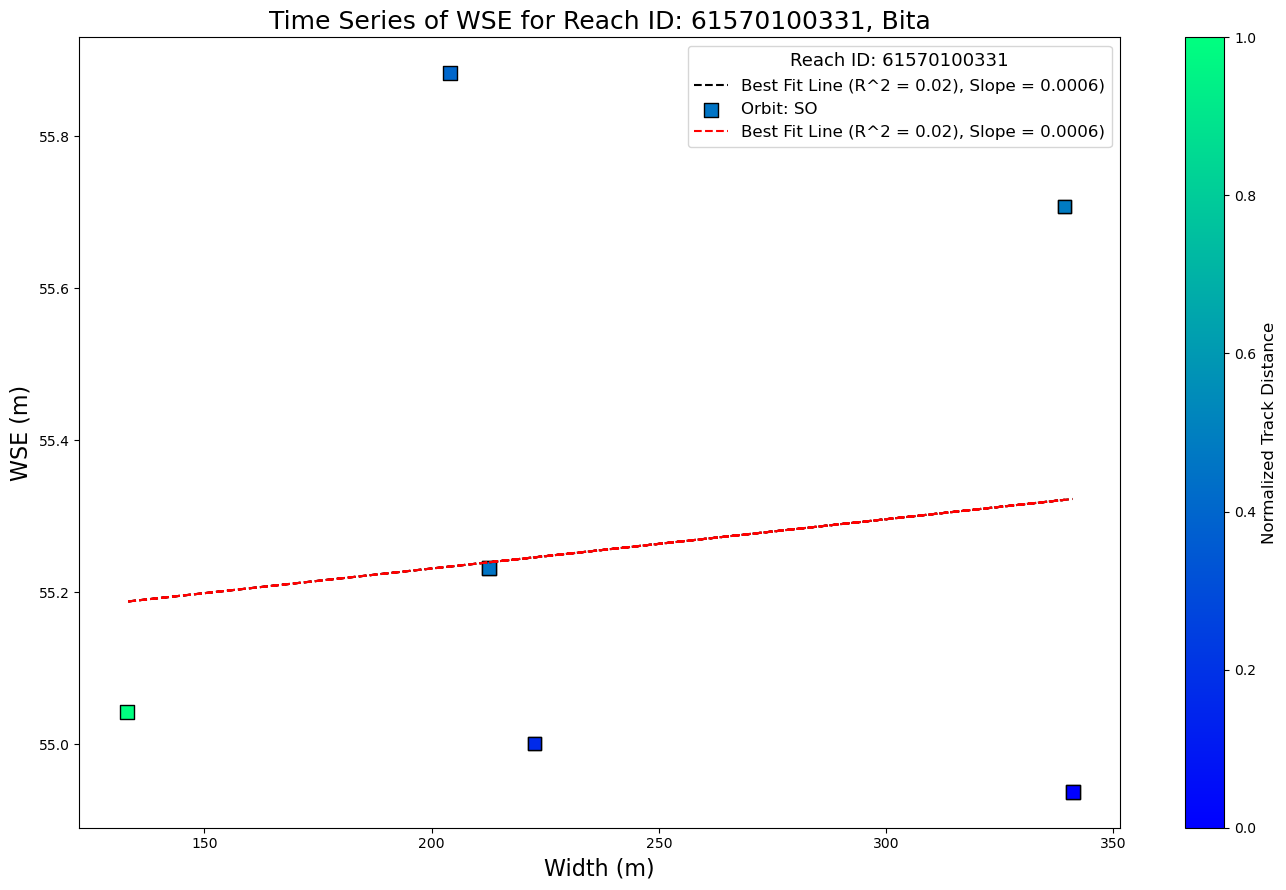

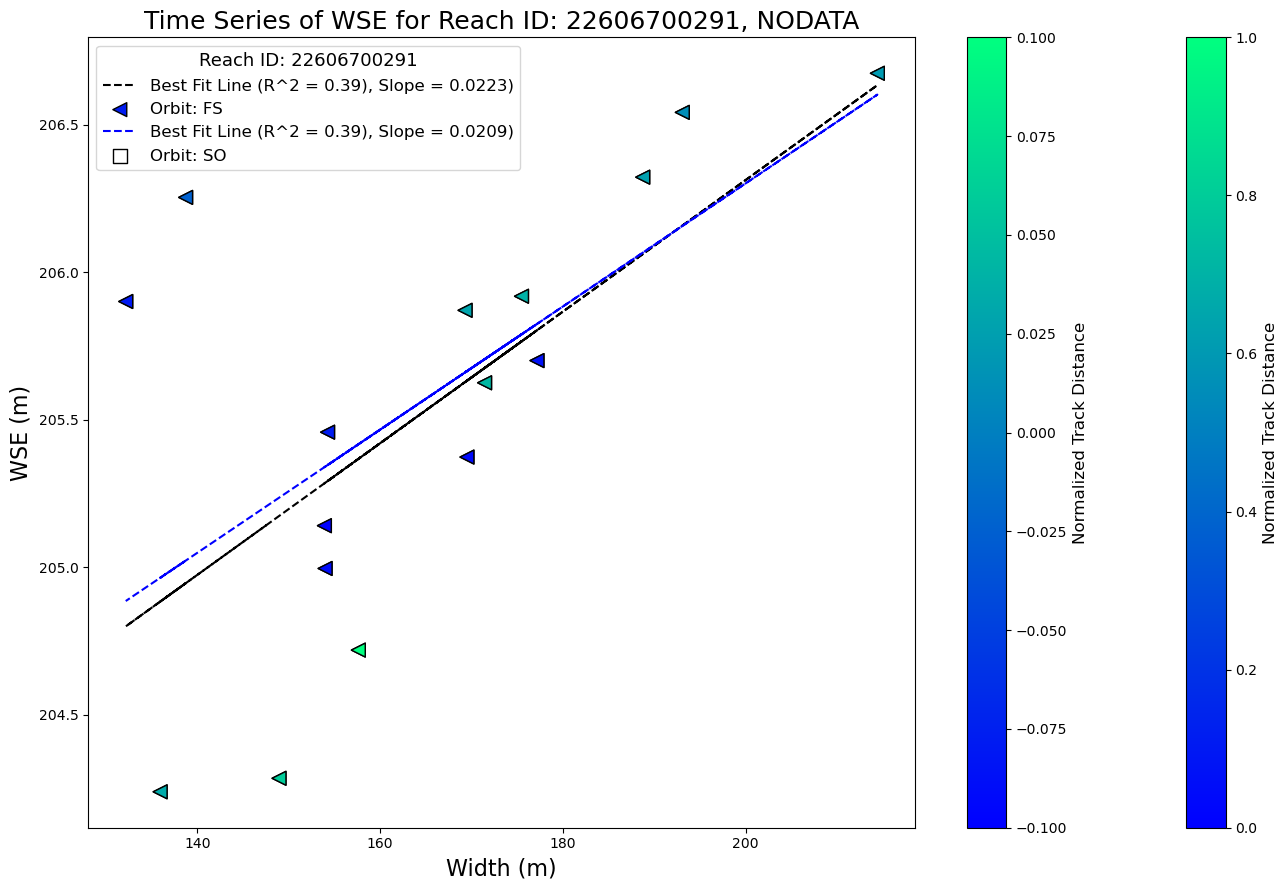

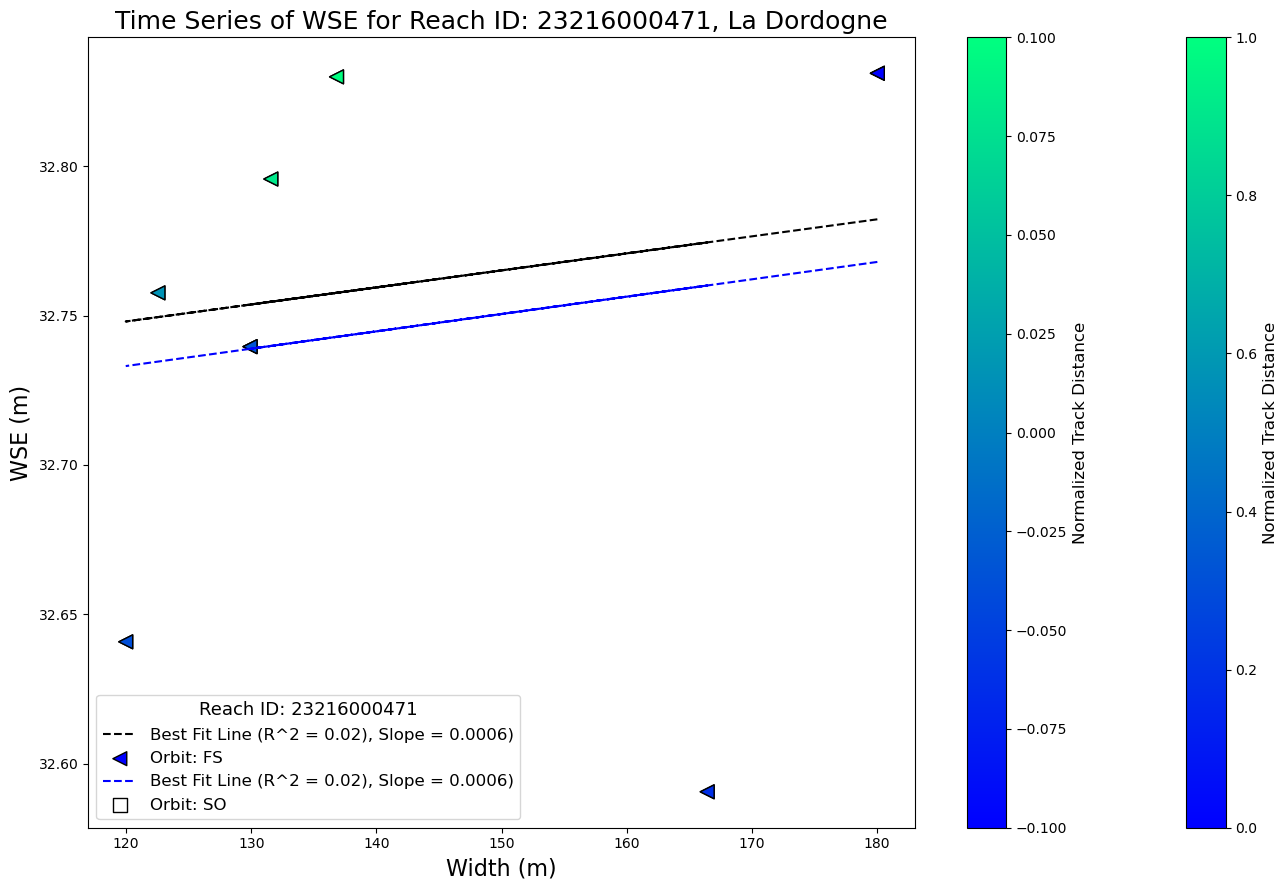

KeyboardInterrupt: 

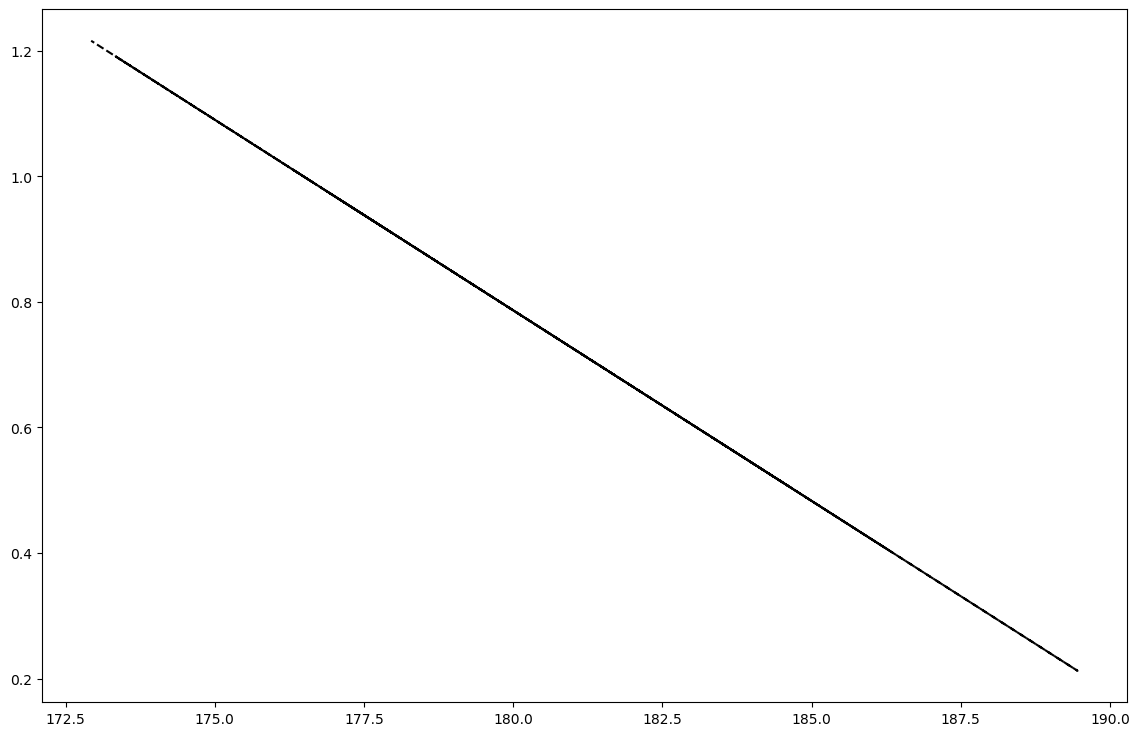

In [68]:
# q_filt is FS & SO
dfs = [df, df_fs, df_so]

regression_df = plot_individual_timeseries_for_reach_ids(dfs=dfs, reach_ids=fsReachList)
print(regression_df)